In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import innvestigate
from utils import utils
from utils import get_results
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import ticker
import scipy.io as io
import numpy as np

def preprocess_model(model_path):
    # Load the trained Keras model
    model = tf.keras.models.load_model(model_path)
    # Add a unique name to each layer
    for i, layer in enumerate(model.layers):
        layer._name = 'layer_' + str(i)
    # Create a new model using the same input and output layers
    inputs = model.input
    outputs = model.output
    new_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    # remove softmax layer for XAI
    model_wo_softmax = innvestigate.model_wo_softmax(new_model)
    return model_wo_softmax


def plot_lrp_series(event, model_path='model/time_model.h5', n=2500, vmin=-0.2, vmax=0.2, vcenter=0, cmap='RdBu_r'):
    """
    Plot the input data and LRP results for each channel of an event using a trained time series-based model.

    Arguments:
    event -- Index of the event to plot
    model_path -- Path to the trained Keras model
    n -- Number of data points to plot (default 2500)
    vmin -- Minimum value for the color scale (default -0.2)
    vmax -- Maximum value for the color scale (default 0.2)
    vcenter -- Center value for the color scale (default 0)
    cmap -- Type of the colormap to use (default 'RdBu_r')

    Returns:
    The matplotlib figure object
    """

    # Load the input data and normalize it
    input_data = utils.norml(windowed_event[event:event+1,:,:])

    # Load the trained Keras model
    model = preprocess_model(model_path)

    # Create an analyzer for the model using the epsilon-LRP method
    analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
    lrp_results = analyzer.analyze(input_data)

    # Set the figure size
    plt.rcParams['figure.figsize'] = [9, 7.5]

    # Define the normalization
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)

    # Loop over each channel and plot the input data and LRP results
    for channel in range(3):

        # Get the input data and LRP results for this channel
        input_data_channel = input_data[0, :n, channel]
        lrp_results_channel = lrp_results[0, :n, channel]

        # Plot the input data
        plt.subplot(3, 2, 2*channel+1)
        plt.plot(input_data_channel)
        plt.title(f'Channel {channel+1}: Input Data')
        plt.xlabel('Time(Samples)')
        plt.ylabel('Amplitude')

        # Plot the LRP results
        plt.subplot(3, 2, 2*channel+2)
        plt.scatter(np.arange(n), input_data_channel, c=lrp_results_channel, s=5, cmap=cmap, norm=norm)
        plt.colorbar()
        plt.title(f'Channel {channel+1}: LRP Results')
        plt.xlabel('Time(Samples)')
        #plt.ylabel('Amplitude')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Save the plot
    return plt.gcf()

def plot_lrp_stft(event, model_path='model/stft_model_addv2.h5', tn=5, cs = 1, vcenter=0, cmap='RdBu_r'):
    """
    Plot the input STFT data and LRP results for each channel of an event using a trained STFT-based model.

    Arguments:
    event -- Index of the event to plot
    model_path -- Path to the trained Keras model
    tn -- Number of color bins to plot (default 5)
    cs -- percent value for the color scale (default 1)
    vcenter -- Center value for the color scale (default 0)
    cmap -- Type of the colormap to use (default 'RdBu_r')

    Returns:
    The matplotlib figure object
    """

    # Load the input data and normalize it
    input_data = utils.norml(windowed_event[event:event+1,:,:])
    input_data_raw = input_data

    # STFT for input data
    input_data = utils.batch_stft(input_data,nfft=128,overlap=0.69)

    # Load the trained Keras model
    model = preprocess_model(model_path)

    # Create an analyzer for the model using the epsilon-LRP method
    analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
    lrp_results = analyzer.analyze(input_data)

    # Set the figure size
    plt.rcParams['figure.figsize'] = [10, 7.5]



    # Set ticks
    my_yticks = ['0','30', '60','90','120']
    my_xticks = ['0','2.5','5','7.5','10','12.5']

    # Loop over each channel and plot the input data and LRP results
    for channel in range(3):

        # Get the input data and LRP results for this channel
        input_data_channel = input_data[0, :,:, channel]
        input_data_raw_channel = input_data_raw[0, :, channel]
        lrp_results_channel = lrp_results[0, :,:, channel]

        # Define the normalization
        # Use np.partition to get the tenth maximum value
        max_value = np.partition(lrp_results_channel.flatten(), -7)[-7]
        vmax = max_value*cs
        vmin = -1*max_value*cs
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)

        # Plot the input raw data
        plt.subplot(3, 3, 3*channel+1)
        plt.plot(input_data_raw_channel)
        plt.title(f'Channel {channel+1}: Input Data',fontsize=10)
        plt.xlabel('Time(s)',fontsize=9)
        plt.ylabel('Normalized Amplitude',fontsize=8,labelpad=-3)
        plt.xticks([0,625,1300,1925,2550,3175],my_xticks)

        # Plot the input STFT
        plt.subplot(3, 3, 3*channel+2)
        plt.imshow(input_data_channel,cmap="jet",origin='lower')
        plt.xlabel('Time(s)',fontsize=9)
        plt.ylabel('Frequency(Hz)',fontsize=8,labelpad=-3)
        plt.title(f'Channel {channel+1}: Input STFT map',fontsize=10)
        plt.yticks([0,15,30,45,62],my_yticks,fontsize=7)
        plt.xticks([0,16,32,47,63,79],my_xticks)
        plt.grid(axis='y', linestyle='-')
        plt.colorbar(pad=0.05)  # Adjust the pad value to control the spacing



        # Plot the STFT-LRP results
        plt.subplot(3, 3, 3*channel+3)
        plt.title(f'Channel {channel+1}: LRP Results',fontsize=10)
        plt.xlabel('Time(s)',fontsize=9)
        plt.ylabel('Frequency(Hz)',fontsize=8,labelpad=-3)
        plt.yticks([0,15,30,45,62],my_yticks,fontsize=7)
        plt.xticks([0,16,32,47,63,79],my_xticks)
        plt.grid(axis='y', linestyle='-')
        plt.imshow(lrp_results_channel,origin='lower',cmap = 'RdBu_r', norm=norm)
        cb = plt.colorbar(pad=0.02)  # Adjust the pad value to control the spacing
        tick_locator = ticker.MaxNLocator(nbins=tn)
        cb.locator = tick_locator
        cb.update_ticks()


    # Adjust the layout of the subplots
    #plt.tight_layout(w_pad=-30, h_pad=1)
    # Adjust layout spacing
    plt.tight_layout(w_pad=1)



    # Save the plot
    return plt.gcf()

#single channel for LRP map
def plot_lrp_stft_1channel(event, model_path='model/stft_model_addv2.h5', tn=5, cs = 1, vcenter=0, cmap='RdBu_r'):
    """
    Plot the input STFT data and LRP results for each channel of an event using a trained STFT-based model.

    Arguments:
    event -- Index of the event to plot
    model_path -- Path to the trained Keras model
    tn -- Number of color bins to plot (default 5)
    cs -- percent value for the color scale (default 1)
    vcenter -- Center value for the color scale (default 0)
    cmap -- Type of the colormap to use (default 'RdBu_r')

    Returns:
    The matplotlib figure object
    """

    # Load the input data and normalize it
    input_data = utils.norml(windowed_event[event:event+1,:,:])
    input_data_raw = input_data

    # STFT for input data
    input_data = utils.batch_stft(input_data,nfft=128,overlap=0.69)

    # Load the trained Keras model
    loaded_model = load_model(model_path)
    model = preprocess_model(model_path)

    #Output classification results
    cat = loaded_model.predict(input_data, verbose=0)
    print(cat)

    # Create an analyzer for the model using the epsilon-LRP method
    analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
    lrp_results = analyzer.analyze(input_data)

    # Set the figure size
    #plt.rcParams['figure.figsize'] = [5, 7.5]


    # Set ticks
    my_yticks = ['0','30', '60','90','120']
    my_xticks = ['0','2.5','5','7.5','10','12.5']

    # Loop over each channel and plot the input data and LRP results
    for channel in range(1):

        # Get the input data and LRP results for this channel
        input_data_channel = input_data[0, :,:, channel]
        input_data_raw_channel = input_data_raw[0, :, channel]
        lrp_results_channel = lrp_results[0, :,:, channel]

        # Define the normalization
        # Use np.partition to get the tenth maximum value
        max_value = np.partition(lrp_results_channel.flatten(), -7)[-7]
        vmax = max_value*cs
        vmin = -1*max_value*cs
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)

        # Plot the input raw data
        plt.subplot(1, 3, 3*channel+1)
        plt.plot(input_data_raw_channel)
        plt.title(f'Channel {channel+1}: Input Data')
        plt.xlabel('Time(s)')
        plt.ylabel('Normalized Amplitude',labelpad=-3)
        plt.xticks([0,625,1300,1925,2550,3175],my_xticks)

        # Plot the input STFT
        plt.subplot(1, 3, 3*channel+2)
        plt.imshow(input_data_channel,cmap="jet",origin='lower')
        plt.xlabel('Time(s)')
        plt.ylabel('Frequency(Hz)',labelpad=-3)
        plt.title(f'Channel {channel+1}: Input STFT map',fontsize=10)
        plt.yticks([0,15,30,45,62],my_yticks)
        plt.xticks([0,16,32,47,63,79],my_xticks)
        plt.grid(axis='y', linestyle='-')
        cb =plt.colorbar(fraction=0.046, pad=0.04)  # Adjust the pad value to control the spacing
        tick_locator = ticker.MaxNLocator(nbins=tn)
        cb.locator = tick_locator
        cb.update_ticks()


        # Plot the STFT-LRP results
        plt.subplot(1, 3, 3*channel+3)
        plt.title(f'Channel {channel+1}: LRP Results',fontsize=10)
        plt.xlabel('Time(s)')
        plt.ylabel('Frequency(Hz)',labelpad=-3)
        plt.yticks([0,15,30,45,62],my_yticks)
        plt.xticks([0,16,32,47,63,79],my_xticks)
        plt.grid(axis='y', linestyle='-')
        plt.imshow(lrp_results_channel,origin='lower',cmap = 'RdBu_r', norm=norm)
        cb =plt.colorbar(fraction=0.046, pad=0.04)  # Adjust the pad value to control the spacing
        tick_locator = ticker.MaxNLocator(nbins=tn)
        cb.locator = tick_locator
        cb.update_ticks()


    # Adjust the layout of the subplots
    #plt.tight_layout(w_pad=-30, h_pad=1)
    # Adjust layout spacing
    plt.tight_layout()



    # Save the plot
    return plt.gcf()

In [ ]:
# load data (event waveform extracted in 15s window)
windowed_event_mat = io.loadmat('./data/windowed_event.mat')
windowed_event = windowed_event_mat['windowed_event']

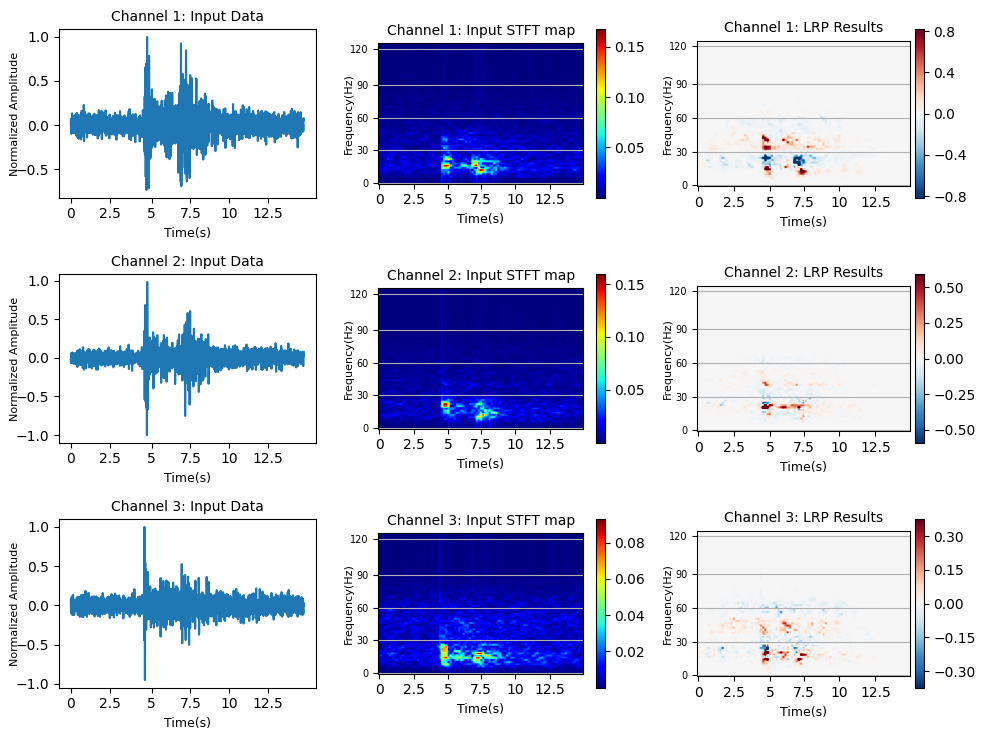

In [ ]:
#STFT
#earthquake 430
a=plot_lrp_stft(430 ,cs = 0.9, tn=5)

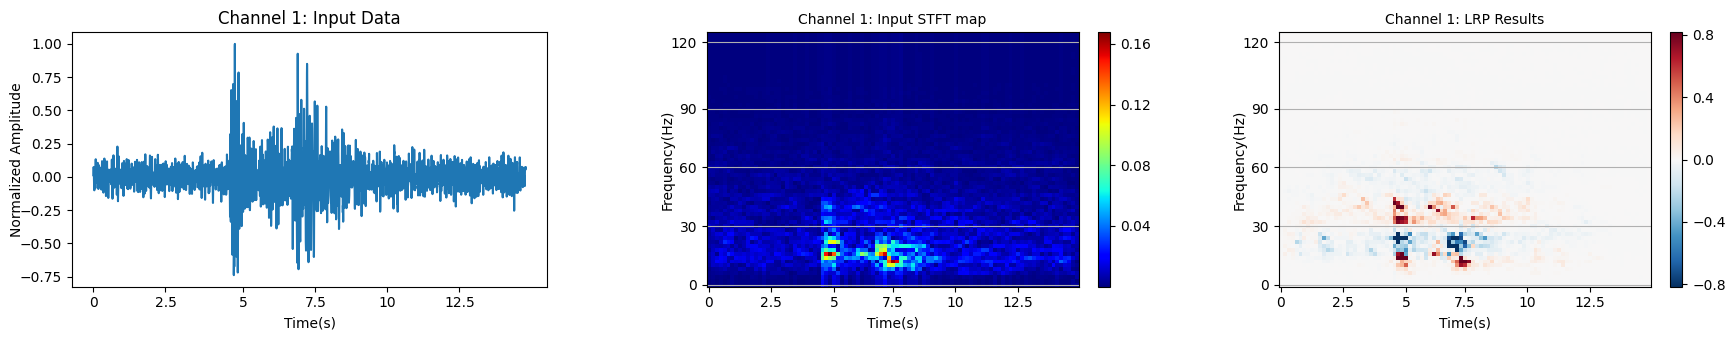

In [ ]:
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(430 ,cs = 0.9, tn=5)

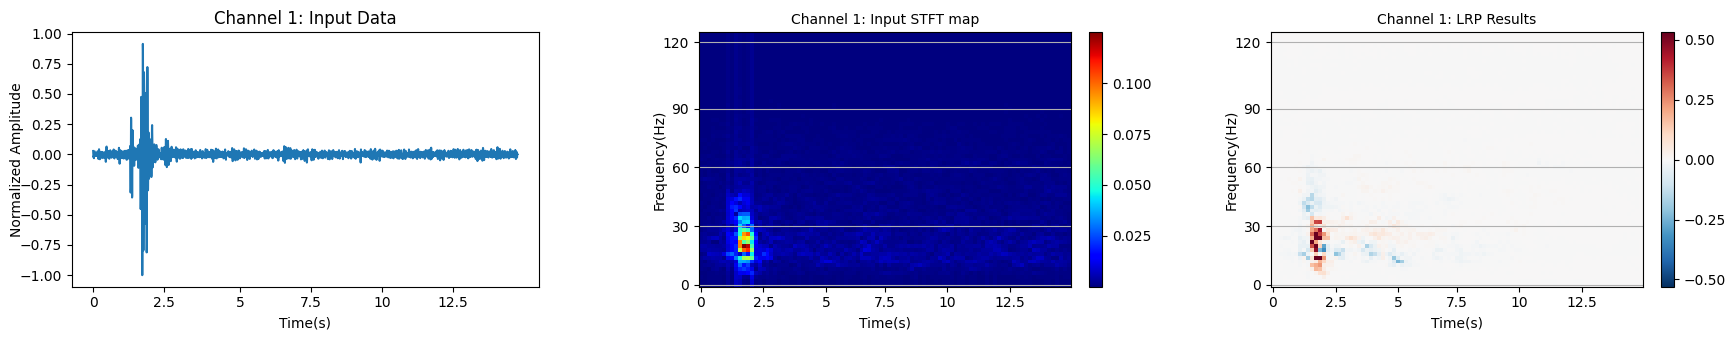

In [ ]:
#STFT
#quake 302
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(302 ,cs = 0.9, tn=5)

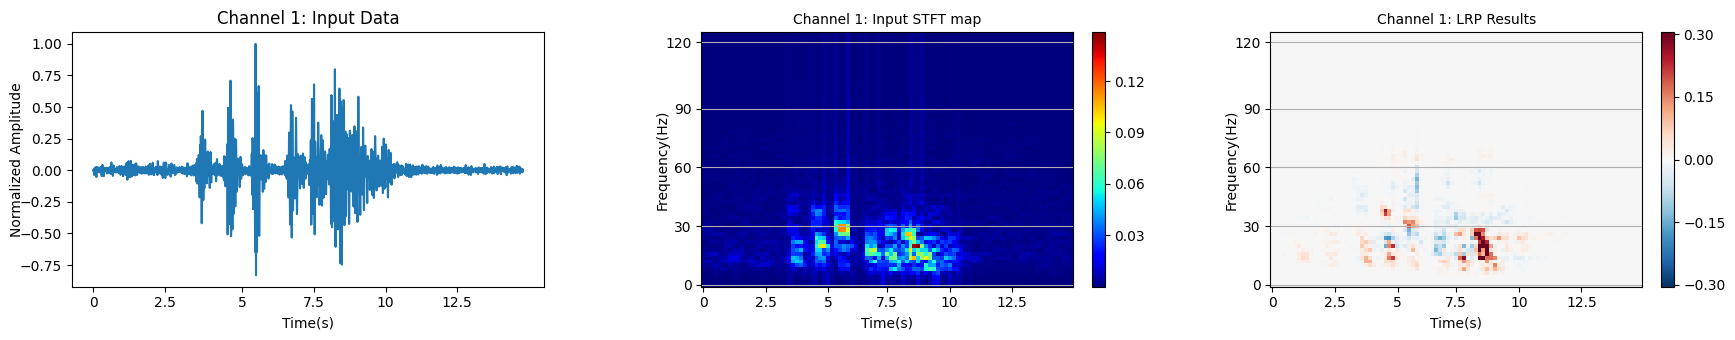

In [ ]:
#STFT
#rockfall 326
a=plot_lrp_stft_1channel(326 ,cs = 0.7, tn=5)

[[9.43604037e-02 9.05627728e-01 3.79481229e-08 1.18806765e-05]]


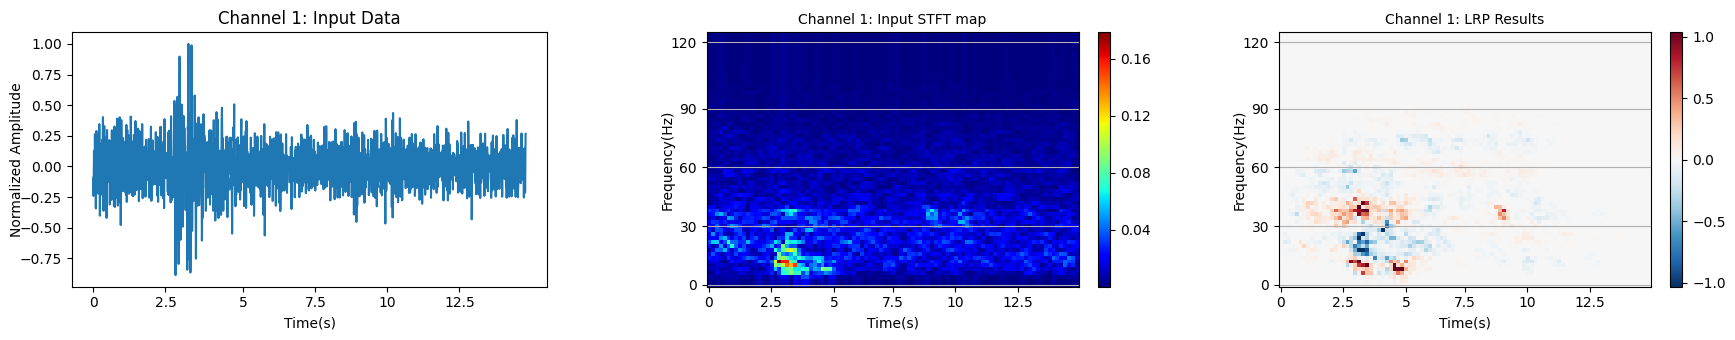

In [ ]:
#1023
#Quake mis to EQ
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(1023 ,cs = 0.9, tn=5)

[[2.1009697e-08 3.2390257e-10 1.0000000e+00 5.3754512e-08]]


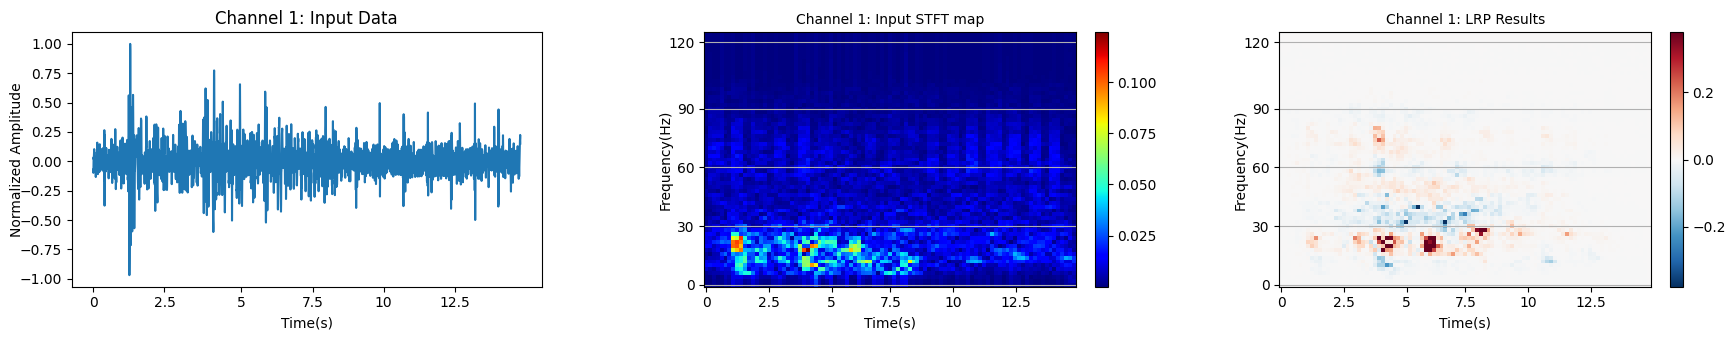

In [ ]:
#664
#EQ mis to rockfall
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(664 ,cs = 0.7, tn=5)

[[9.9999988e-01 6.1928084e-08 8.3625800e-09 3.0410680e-12]]


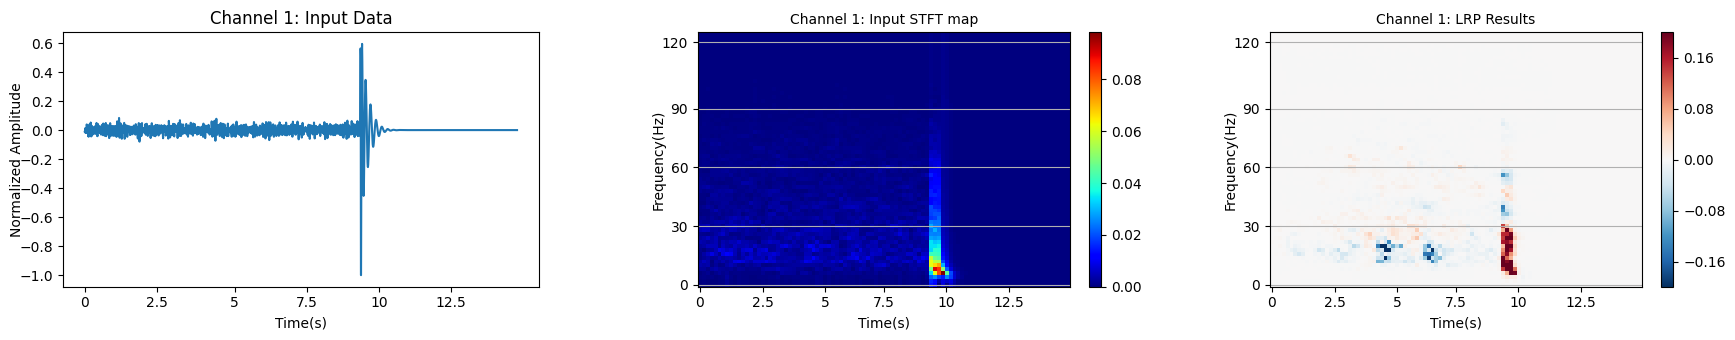

In [ ]:
#464
#correction: EQ to quake
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(464 ,cs = 0.7, tn=5)

[[7.4767479e-05 1.6390644e-10 2.1817437e-11 9.9992526e-01]]


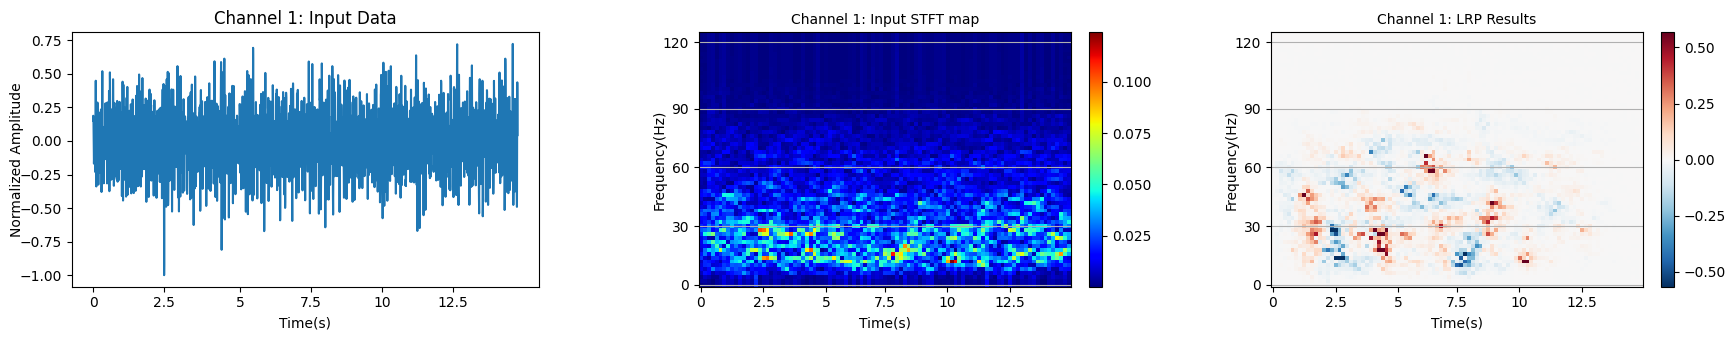

In [ ]:
#368
#correction: quake to noise
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(368 ,cs = 0.7, tn=5)

[[6.0102543e-06 1.2771070e-09 9.9999404e-01 1.5180643e-08]]


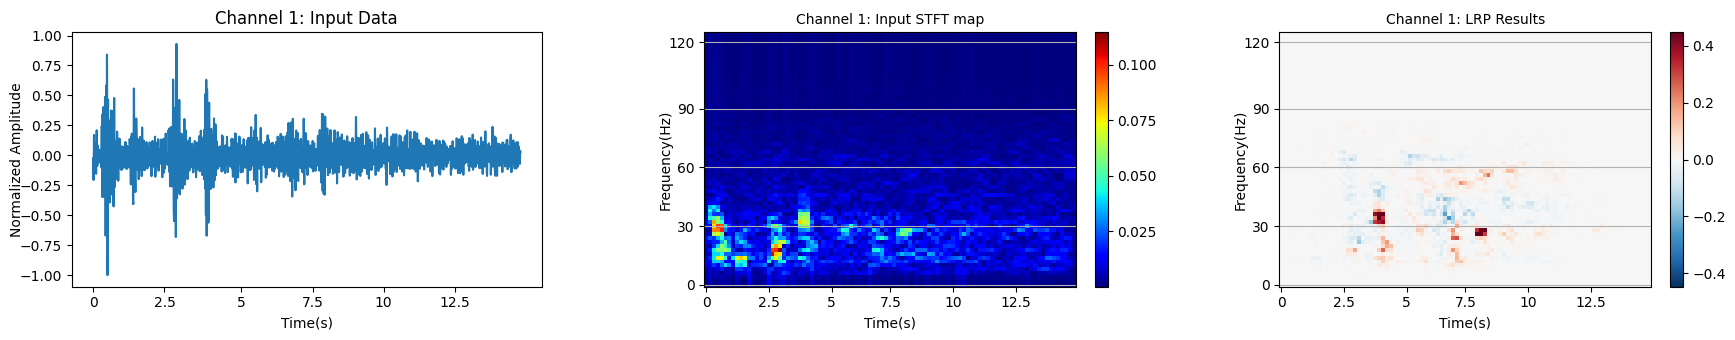

In [ ]:
#1002
#correction: quake to rockfall
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(1002 ,cs = 1, tn=5)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[4.8292655e-05 8.5496082e-10 2.8357511e-14 9.9995172e-01]]


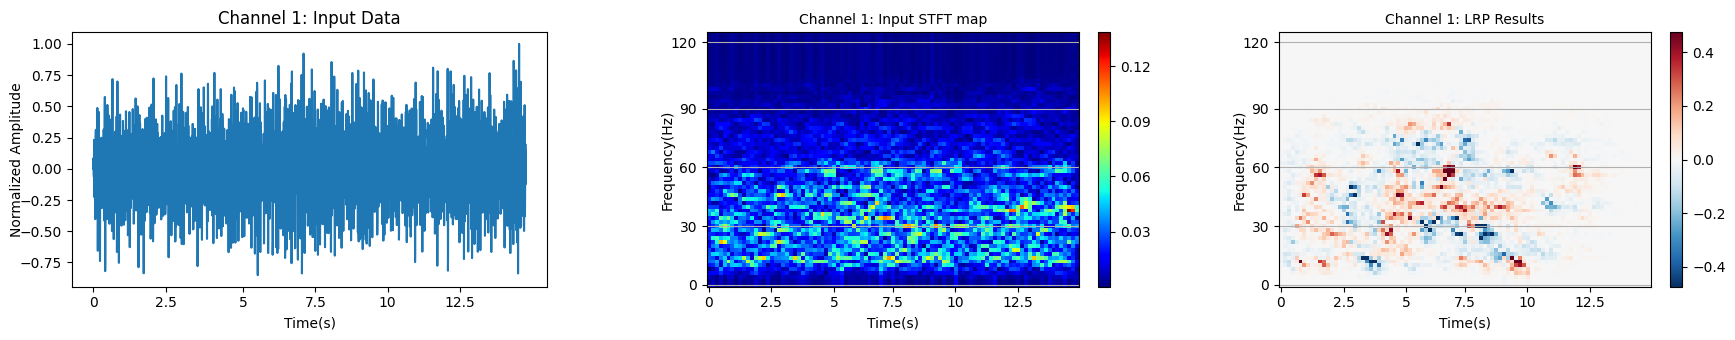

In [ ]:
#512
#correction: equake to noise
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(512 ,cs = 0.7, tn=5)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[1.6281906e-10 4.4504084e-12 1.0000000e+00 2.1812005e-10]]


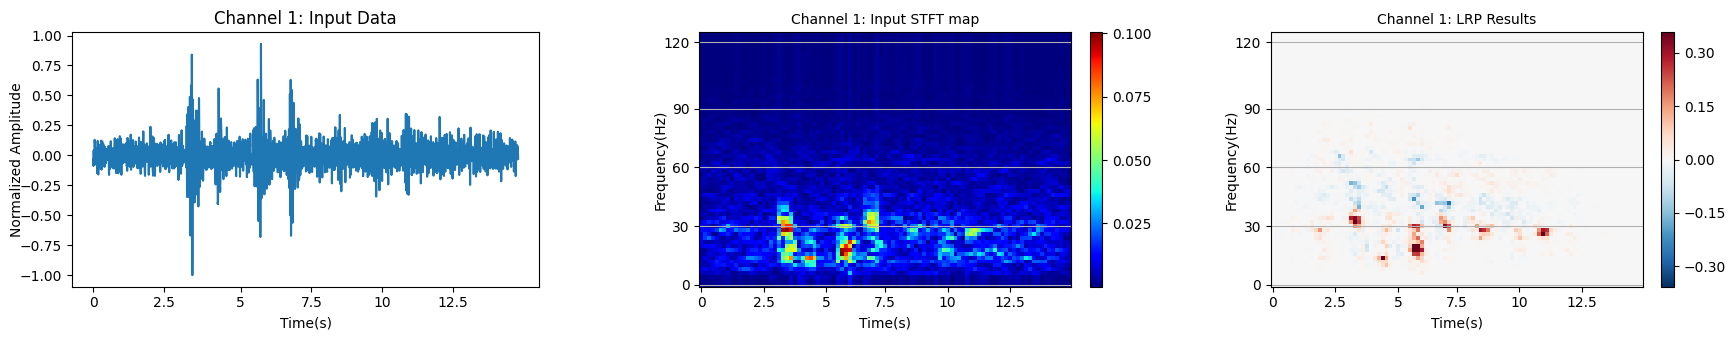

In [ ]:
a=plot_lrp_997_stft(1002 ,cs = 1, tn=5)

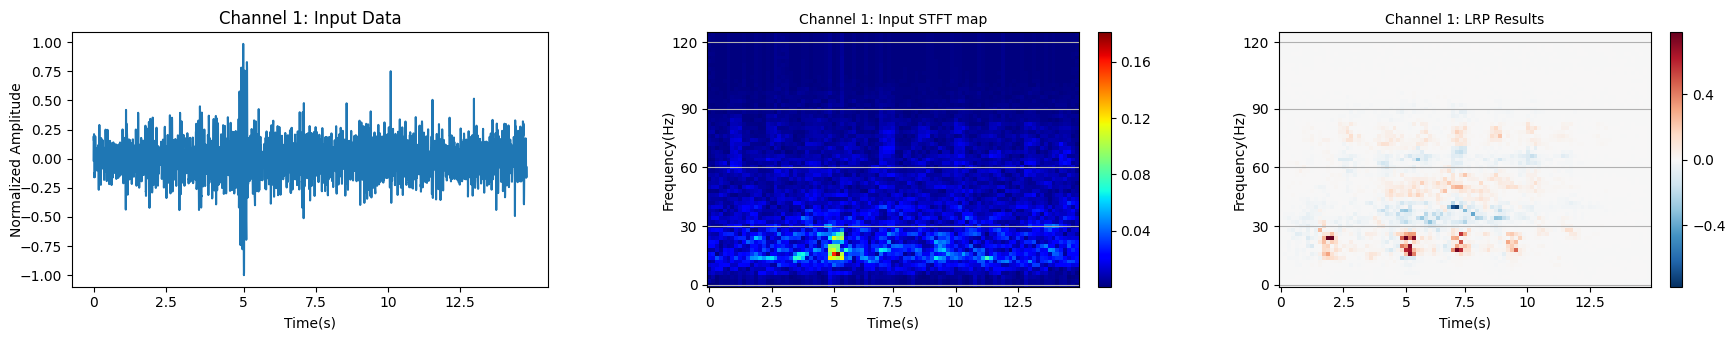

In [ ]:
a=plot_lrp_stft_997(571 ,cs = 1.1, tn=5)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


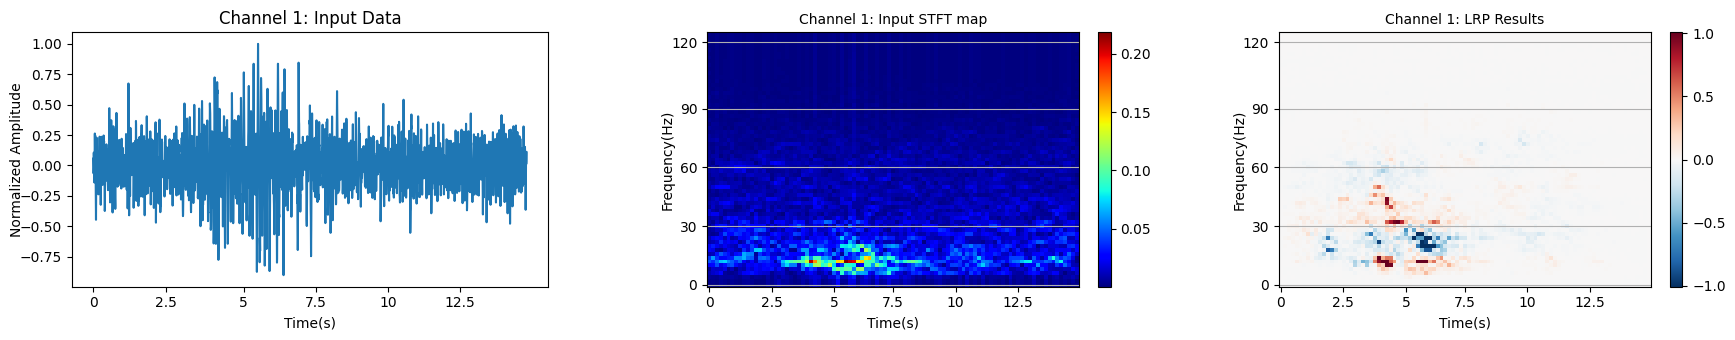

In [ ]:
#STFT
#misclassification noise
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_997(671 ,cs = 0.9, tn=5)

[[1.0000000e+00 1.4875089e-14 2.6935897e-16 3.5245470e-12]]


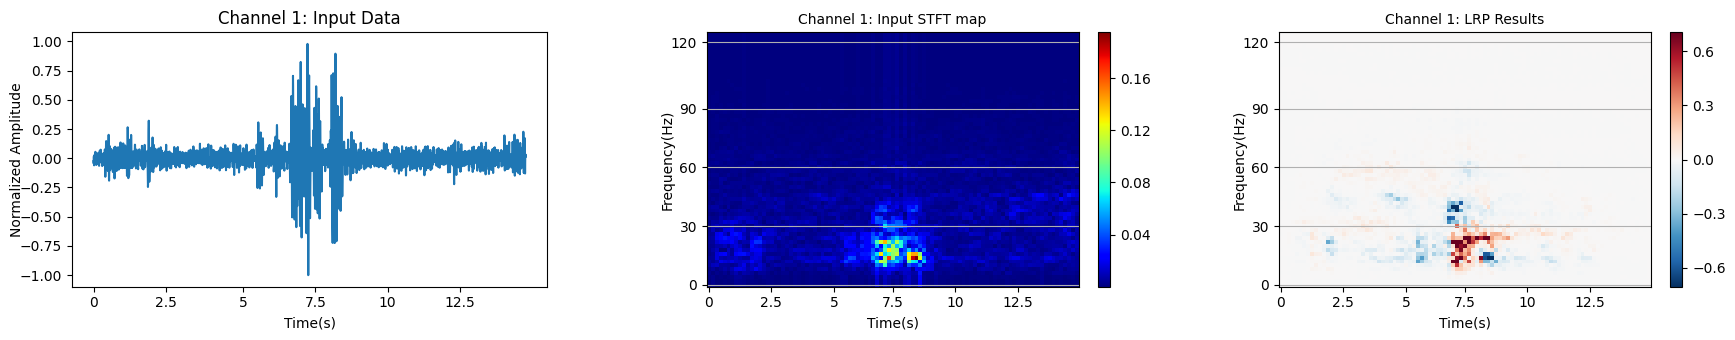

In [ ]:
#STFT
#rockfall 513
a=plot_lrp_stft_1channel(513 ,cs = 0.7, tn=5)

[[7.6731455e-01 2.0276766e-06 2.3267566e-01 7.7965169e-06]]


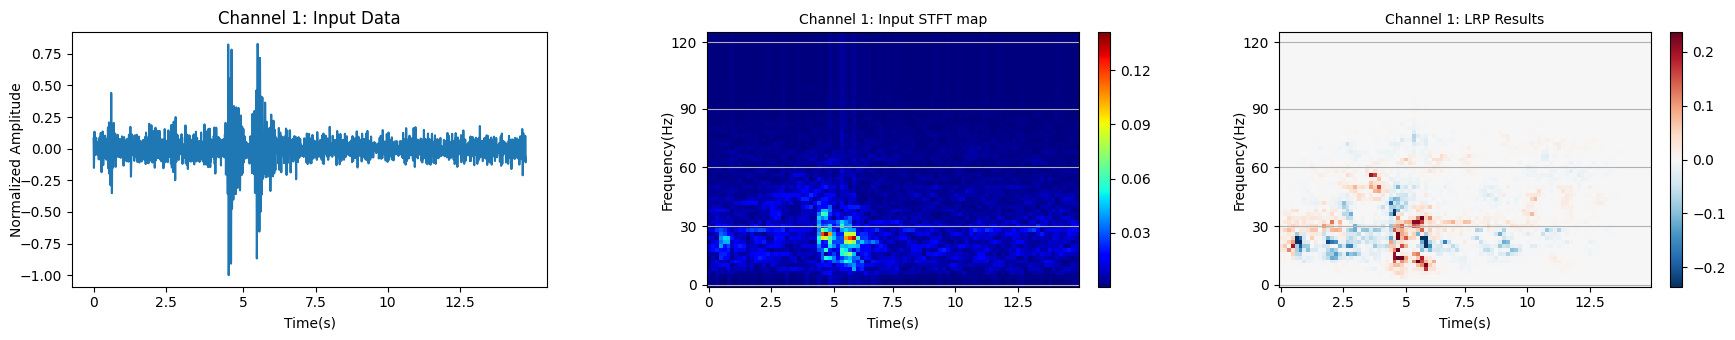

In [ ]:
#737
#correction: quake to rockfall
plt.rcParams['figure.figsize'] = [35*0.5, 7*0.5]
a=plot_lrp_stft_1channel(737 ,cs = 1, tn=5)